Notebook to prepare simple OBC files for T&S for Johnstone Strait from Thomson, 1981 (The book)

Corrected to Full Depth 2015-12-30

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as NC
from salishsea_tools import nc_tools

For tracer fields, (T,S) use bathymetry file

In [2]:
fB = NC.Dataset('../../../nemo-forcing/grid/bathy_meter_SalishSea2.nc','r')
D = fB.variables['Bathymetry'][:]
lat = fB.variables['nav_lat'][:]
print lat.shape
lon = fB.variables['nav_lon'][:]

(898, 398)


For depth we need the real depth, use the file Doug created.

In [3]:
fT = NC.Dataset('../../../nemo-forcing/grid/grid_bathy.nc')
nc_tools.show_dataset_attrs(fT)
deptht = fT.variables['deptht']
depth_out = deptht[:]
depths = fT.variables['grid_bathy']
depth = depths[:]
depth[:,:,0] = depth[:,:,1]
depth[:,897,:] = depth[:,896,:]
print depth.shape

file format: NETCDF4
Conventions: CF-1.6
title: NEMO z-partial-step Grid Level Depths
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/bathymetry/NEMO-GridBathy.ipynb
references: https://bitbucket.org/salishsea/nemo-forcing/src/tip/grid/grid_bathy.nc
history: [2014-01-14 13:53:09] Created netCDF4 zlib=True dataset.
comment: Calculated by a 1-step NEMO run.
(40, 898, 398)


Construct our temperature and salinity profiles from plots 12.3 and 12.4 and description in text.    
   Temperature: winter, 7 degrees  text description   
   Temperature: summer, 9 degrees  text description   
   If I put these in as two numbers, it will use 7 as end of March and 9 as end of September.... good enough   
   Salinity: surface 30 to 31.5 at 100 m 31.5 to 32 at 325 m   
   (note, the 30 comes from the text, figure is 31 at surface)

From JohnstoneStraitBoundary where we characterized the nothern boundary we know our startj and endj values.

In [4]:
starti = 32
endi = 62
lengthi = endi-starti

Make boundary 10 wide (to follow AMM12)

In [5]:
r = 10

Open and make our file for TS

In [8]:
nemo = NC.Dataset('SalishSea2_North_tra.nc', 'w', zlib=True)

# dataset attributes
nc_tools.init_dataset_attrs(
    nemo, 
    title='Simple Temperature & Salinity Boundary Conditions for Northern Boundary', 
    notebook_name='PrepareSimpleTS-Johnstone', 
    nc_filepath='../../../nemo-forcing/open_boundaries/north/SalishSea2_North_tra.nc',
    comment='Rough T & S data from Thomson 1981, extended full-depth') 

# dimensions
nemo.createDimension('xbT', lengthi*r)
nemo.createDimension('yb', 1)
nemo.createDimension('deptht',size = len(depth_out))
nemo.createDimension('time_counter', None)

# variables
# deptht
deptht = nemo.createVariable('deptht', 'float32', ('deptht',))
deptht.long_name = 'Vertical T Levels'
deptht.units = 'm'
deptht.positive = 'down'
deptht.valid_range = np.array((4., 428.))
# time_counter
time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.long_name = 'Time axis'
time_counter.axis = 'T'
time_counter.units = 'half years'
# nav_lat and nav_lon
nav_lat = nemo.createVariable('nav_lat','float32',('yb','xbT'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lon = nemo.createVariable('nav_lon','float32',('yb','xbT'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
# votemper
votemper = nemo.createVariable('votemper', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
votemper.units = 'degC'
votemper.long_name = 'Temperature'   
votemper.coordinates = 'nav_lon nav_lat deptht time_counter'
votemper.grid = 'SalishSea2'
# vosaline

vosaline = nemo.createVariable('vosaline', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
vosaline.units = 1
vosaline.long_name = 'Practical Salinity'  
vosaline.coordinates = 'nav_lon nav_lat deptht time_counter'
vosaline.grid = 'SalishSea2'
# nbidta, ndjdta, ndrdta
nbidta = nemo.createVariable('nbidta', 'int32' , ('yb','xbT'))
nbidta.long_name = 'i grid position'
nbidta.units = 1
nbjdta = nemo.createVariable('nbjdta', 'int32' , ('yb','xbT'))
nbjdta.long_name = 'j grid position'
nbjdta.units = 1
nbrdta = nemo.createVariable('nbrdta', 'int32' , ('yb','xbT'))
nbrdta.long_name = 'position from boundary'
nbrdta.units = 1

file format: NETCDF4
Conventions: CF-1.6
title: Simple Temperature & Salinity Boundary Conditions for Northern Boundary
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/PrepareSimpleTS-Johnstone.ipynb
references: https://bitbucket.org/salishsea/nemo-forcing/src/tip/open_boundaries/north/SalishSea2_North_tra.nc
history: [2015-12-30 13:34:39] Created netCDF4 zlib=True dataset.
comment: Rough T & S data from Thomson 1981, extended full-depth


In [9]:
# values
# depths, time counter
deptht[:] = depth_out
time_counter[0:2] = range(0,2)
# nav_lat, nav_lon, nbidta, nbjdta
for ir in range(0,r):
    j = 896-ir
    nav_lat[0,ir*lengthi:(ir+1)*lengthi] = lat[j,starti:endi]
    nav_lon[0,ir*lengthi:(ir+1)*lengthi] = lon[j,starti:endi]
    nbidta[0,ir*lengthi:(ir+1)*lengthi] = range(starti,endi)
    nbjdta[0,ir*lengthi:(ir+1)*lengthi] = j
    nbrdta[0,ir*lengthi:(ir+1)*lengthi] = ir
print nbjdta[0,lengthi:lengthi*2]

[895 895 895 895 895 895 895 895 895 895 895 895 895 895 895 895 895 895
 895 895 895 895 895 895 895 895 895 895 895 895]


In [10]:
# votemper
print votemper.shape
t=0
for ib in range(0,lengthi*r):
    votemper[t,:,0,ib] = 7.0
t=1
for ib in range(0,lengthi*r):
    votemper[t,:,0,ib] = 9.0    

(2, 40, 1, 300)


In [21]:
# vosaline
print vosaline.shape
t = 0
for ib in range(0, lengthi*r):
    vosaline[t, 0, 0, ib] = 30.
    for d in range(1,40):
        dep = max(0, depth[d, nbjdta[0,ib], nbidta[0,ib]])
        if dep == 0:
            vosaline[t, d, 0, ib] = vosaline[t, d-1, 0, ib]
        elif dep < 100:
            vosaline[t,d,0,ib] = 30. + 1.5*dep/100.
        else:
            vosaline[t,d,0,ib] = 31.5 + 0.5*(dep-100.)/225.
vosaline[1] = vosaline[0]

(2, 40, 1, 300)


<matplotlib.colorbar.Colorbar instance at 0x7f2d4d00cf38>

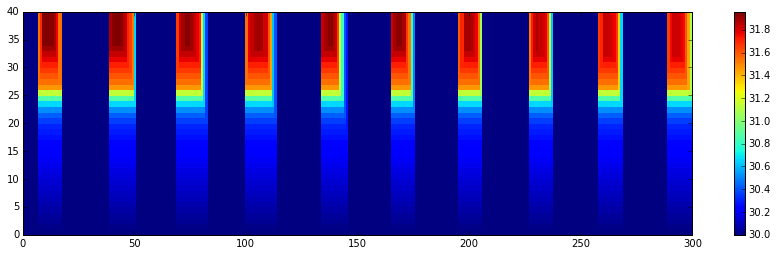

In [22]:
plt.figure(figsize=(15,4))
plt.pcolormesh(vosaline[0,:,0])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f2d4ce81050>

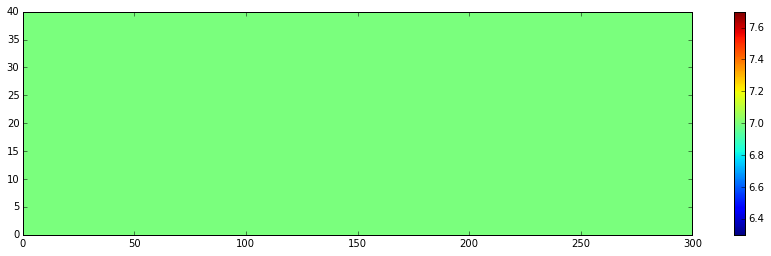

In [23]:
plt.figure(figsize=(15,4))
plt.pcolormesh(votemper[0,:,0])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f2d4cd4b7a0>

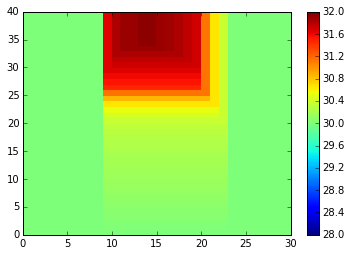

In [24]:
ir = 2
plt.figure(figsize=(6,4))
plt.pcolormesh(vosaline[0,:,0,ir*lengthi:(ir+1)*lengthi],vmax=32,vmin=28)
plt.colorbar()

In [25]:
nemo.history = """
[2014-02-02 18:26] Created
[2014-03-18 16:10] grid point fixed (fortran/python)
[2015-12-30 13:48] Extended salinity downwards to all depths
"""

In [26]:
nc_tools.check_dataset_attrs(nemo)

In [27]:
# and close
nemo.close()